# 1: Replicate the baseline AI methodology using the open dataset 

## Install Requirements & Load Packages

<!-- conda env create -f environment.yml -->

In [ ]:
# Import packages
import keras
keras.config.set_backend("tensorflow")

from keras.models import Model
from keras.layers import *
from keras.saving import load_model
from keras.optimizers import *
from keras.losses import * 
from keras import backend as K
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
import numpy as np
import pandas as pd
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import rasterio
import requests
import pyunpack  
import matplotlib.pyplot as plt
import PIL
from PIL import Image

from sklearn.metrics import *

In [80]:
# Document the used dependenies
# conda env export > environment.yml

## Download & Preprocess Datasets

In [ ]:
# Specify whether to download data or read in
download = False
base_dir = r"./Amazon Forest Dataset/"

### RGB

In [6]:
# Download data

# Path to patool executable inside your conda env
patool_path = r"C:\Users\Gebruiker\AppData\Local\r-miniconda\envs\deforestation\Scripts\patool.exe"

if download:
    url = 'https://zenodo.org/record/3233081/files/Amazon%20Forest%20Dataset.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    with open('data.rar', 'wb') as f:
        f.write(r.content)

# Use explicit patool_path
pyunpack.Archive('data/data.rar').extractall('', patool_path=patool_path)

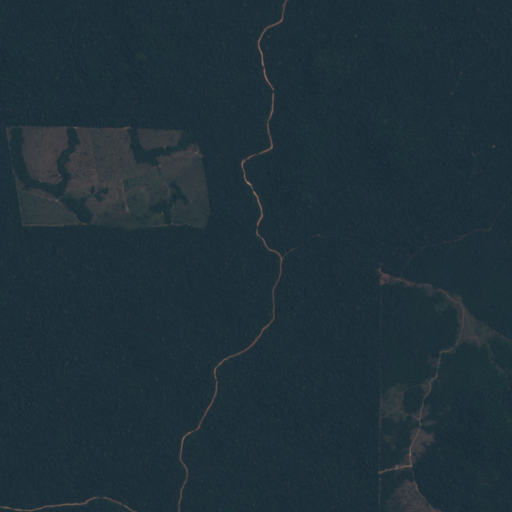

In [ ]:
# Show example image from training data
PIL.Image.open(r"{}Training/images/Amazon_1110.tiff_25.tiff".format(base_dir))

In [ ]:
# %run preprocessing/preprocess-rgb-data.py

### 4-band Amazon

In [ ]:
download = False # True, if files don't already exist in same directory
base_dir2 = r"./AMAZON/"

In [ ]:
# Download data Amazon

# Path to patool executable inside your conda env
patool_path = r"C:\Users\Gebruiker\AppData\Local\r-miniconda\envs\deforestation\Scripts\patool.exe"

if download:
    url = 'https://zenodo.org/record/4498086/files/AMAZON.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    with open('data2.rar', 'wb') as f:
        f.write(r.content)

# Use explicit patool_path
pyunpack.Archive('data2.rar').extractall('', patool_path=patool_path)

In [ ]:
# %run preprocessing/preprocess-4band-amazon-data.py

### 4-band Atlantic Forest

In [ ]:
download = False # True if files don't already exist in same directory
base_dir3 = r"./ATLANTIC FOREST/"

In [ ]:
# Download data (Atlantic Forest)

# Path to patool executable inside your conda env
patool_path = r"C:\Users\Gebruiker\AppData\Local\r-miniconda\envs\deforestation\Scripts\patool.exe"

if download:
    url = 'https://zenodo.org/record/4498086/files/ATLANTIC%20FOREST.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    with open('data3.rar', 'wb') as f:
        f.write(r.content)

# Use explicit patool_path
pyunpack.Archive('data3.rar').extractall('', patool_path=patool_path)

In [ ]:
# %run preprocessing/preprocess-4band-atlantic-forest-data.py

### Show sample of 3 datasets:

VISUALIZING TRAINING DATA FROM ALL DATASETS

Processing: Amazon


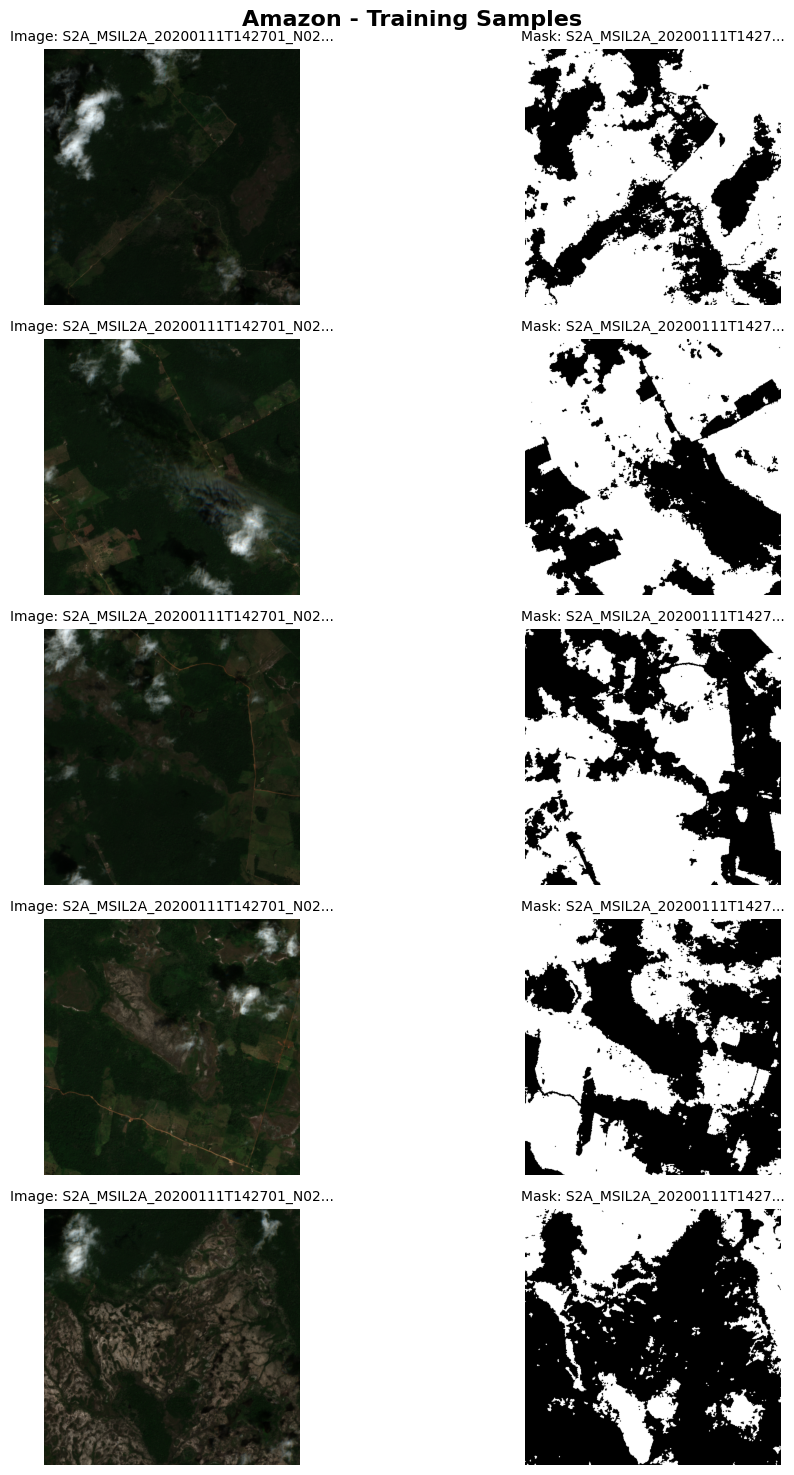

 Showed 5 samples from Amazon

Processing: Atlantic Forest


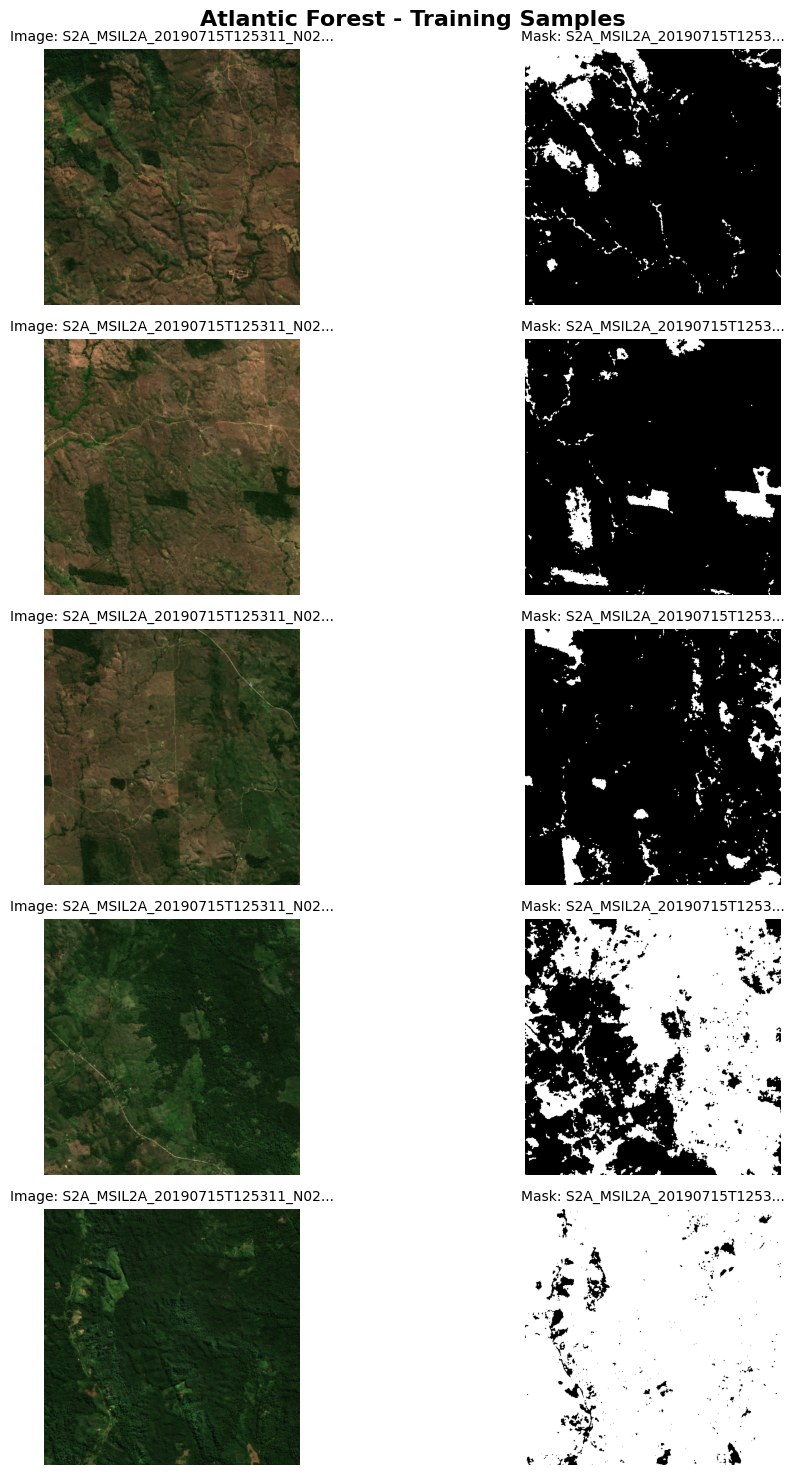

 Showed 5 samples from Atlantic Forest

Processing: Amazon Forest Dataset


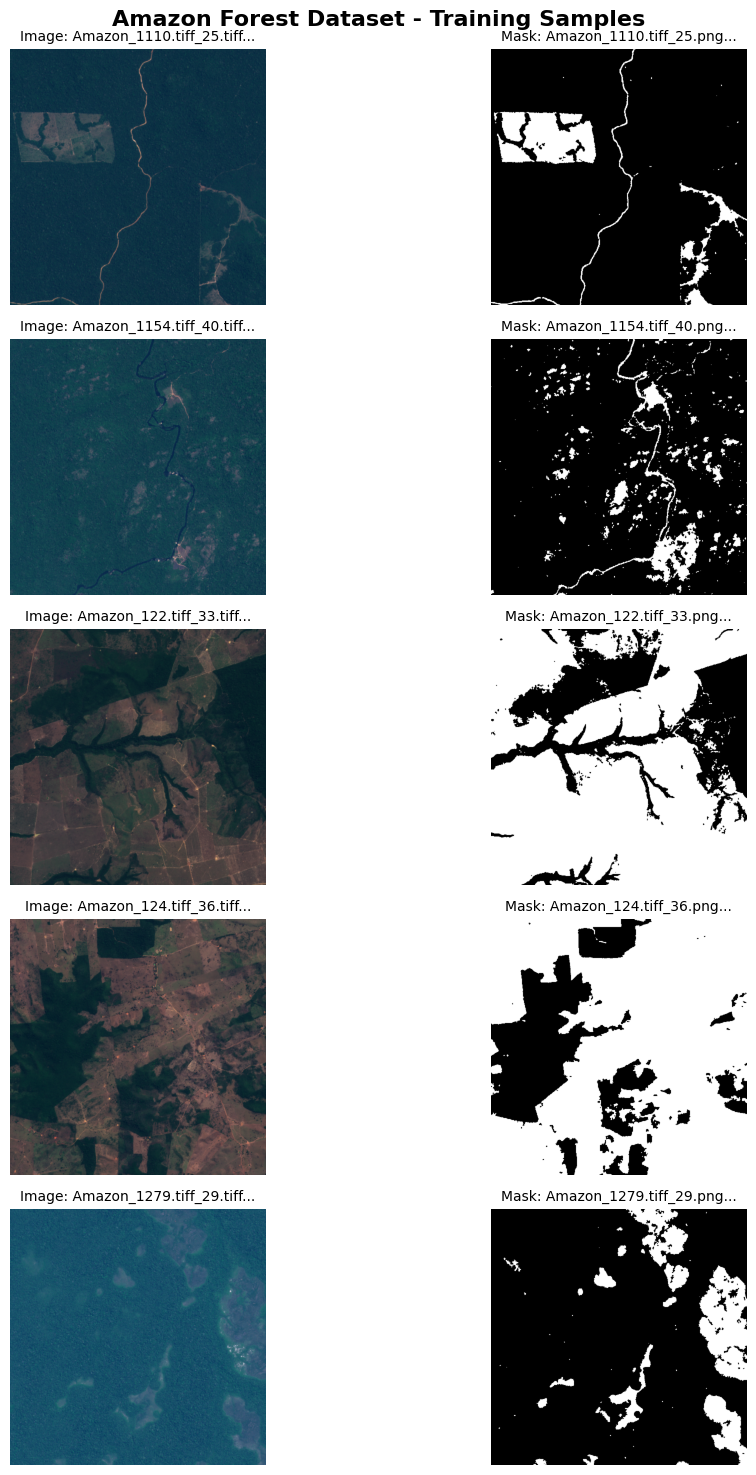

 Showed 5 samples from Amazon Forest Dataset

VISUALIZATION COMPLETE


In [ ]:
# Define all datasets
datasets = {
    'Amazon': {
        'images': 'data/AMAZON/Training/image',
        'masks': 'data/AMAZON/Training/label',
        'img_ext': ['.tif'],
        'mask_ext': ['.tif']
    },
    'Atlantic Forest': {
        'images': 'data/ATLANTIC FOREST/Training/image',
        'masks': 'data/ATLANTIC FOREST/Training/label',
        'img_ext': ['.tif'],
        'mask_ext': ['.tif']
    },
    'Amazon Forest Dataset': {
        'images': 'data/Amazon Forest Dataset/Training/images',
        'masks': 'data/Amazon Forest Dataset/Training/masks',
        'img_ext': ['.tiff'],
        'mask_ext': ['.png']
    }
}

def show_dataset_samples(dataset_name, img_folder, mask_folder, img_ext, mask_ext, n=5):
    """Show n samples from a dataset"""
    
    # Get image files
    img_files = sorted([f for f in os.listdir(img_folder) 
                       if any(f.endswith(ext) for ext in img_ext)])[:n]
    
    if len(img_files) == 0:
        print(f"No image files found in {img_folder}")
        return
    
    # Create plot
    fig, axes = plt.subplots(n, 2, figsize=(12, n*3))
    fig.suptitle(f'{dataset_name} - Training Samples', fontsize=16, fontweight='bold')
    
    for i, img_file in enumerate(img_files):
        try:
            # Load image with rasterio (for .tif/.tiff)
            with rasterio.open(os.path.join(img_folder, img_file)) as src:
                img = src.read()
                
                # Handle multi-band images
                if img.shape[0] >= 3:
                    img = np.transpose(img[:3], (1, 2, 0))
                else:
                    img = img[0]
                
                # Normalize to 0-1
                img = (img - img.min()) / (img.max() - img.min())
            
            axes[i, 0].imshow(img)
            axes[i, 0].set_title(f'Image: {img_file[:30]}...', fontsize=10)
            axes[i, 0].axis('off')
            
            # Find corresponding mask
            base_name = os.path.splitext(img_file)[0]
            mask_found = False
            
            for ext in mask_ext:
                mask_path = os.path.join(mask_folder, base_name + ext)
                if os.path.exists(mask_path):
                    # Load mask - use PIL for PNG, rasterio for TIF
                    if ext == '.png':
                        mask = np.array(Image.open(mask_path))
                    else:
                        with rasterio.open(mask_path) as src:
                            mask = src.read(1)
                    
                    axes[i, 1].imshow(mask, cmap='gray')
                    axes[i, 1].set_title(f'Mask: {base_name + ext}'[:30] + '...', fontsize=10)
                    mask_found = True
                    break
            
            if not mask_found:
                axes[i, 1].text(0.5, 0.5, f'Mask not found\n(looked for: {base_name}.*)', 
                               ha='center', va='center', fontsize=8)
            axes[i, 1].axis('off')
            
        except Exception as e:
            print(f"Error loading {img_file}: {e}")
            axes[i, 0].text(0.5, 0.5, f'Error:\n{str(e)[:50]}', ha='center', va='center', fontsize=8)
            axes[i, 0].axis('off')
            axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f" Showed {len(img_files)} samples from {dataset_name}\n")

# Show samples for all datasets
print("=" * 60)
print("VISUALIZING TRAINING DATA FROM ALL DATASETS")
print("=" * 60 + "\n")

for name, config in datasets.items():
    if os.path.exists(config['images']):
        print(f"Processing: {name}")
        show_dataset_samples(name, 
                           config['images'], 
                           config['masks'],
                           config['img_ext'],
                           config['mask_ext'],
                           n=5)
    else:
        print(f" {name}: Path not found - {config['images']}\n")

print("=" * 60)
print("VISUALIZATION COMPLETE")
print("=" * 60)

## Adjustments to make training-ready and match way-of-working from paper

In [25]:
import glob
def load_npy_list(directory):
    files = sorted(glob.glob(os.path.join(directory, "*.npy")))
    arrays = [np.load(f) for f in files]
    return arrays, files

### RGB

In [33]:
BASE_DIR = r"data/amazon-processed-regular"

train_img_dir = os.path.join(BASE_DIR, "training", "images")
train_msk_dir = os.path.join(BASE_DIR, "training", "masks")
val_img_dir   = os.path.join(BASE_DIR, "validation", "images")
val_msk_dir   = os.path.join(BASE_DIR, "validation", "masks")

training_images, training_image_files   = load_npy_list(train_img_dir)
training_masks,  training_mask_files    = load_npy_list(train_msk_dir)
validation_images, validation_img_files = load_npy_list(val_img_dir)
validation_masks,  validation_msk_files = load_npy_list(val_msk_dir)

print(len(training_images), len(validation_images))
print("Example shape:", training_images[0].shape)

30 15
Example shape: (1, 512, 512, 3)


In [34]:
# Add some training images to validation data to increase size of validation set
for i in range(25,30):
  validation_images.append(training_images[i].reshape(1,512,512,3))
  validation_masks.append(training_masks[i].reshape(1,512,512,1))

# Remove five images from training data, which has been added to validation data
training_images = training_images[0:25]
training_masks = training_masks[0:25]

print("Train size:", len(training_images))
print("Val size:", len(validation_images))

Train size: 25
Val size: 20


In [28]:
# Create TensorFlow datasets for validation sets
validation_df = tf.data.Dataset.from_tensor_slices((validation_images, validation_masks))

### 4-band Amazon

In [35]:
BASE_DIR = r"data/amazon-processed-large" 

train_img_dir2 = os.path.join(BASE_DIR, "training", "images")
train_msk_dir2 = os.path.join(BASE_DIR, "training", "masks")
val_img_dir2   = os.path.join(BASE_DIR, "validation", "images")
val_msk_dir2   = os.path.join(BASE_DIR, "validation", "masks")

training_images2, training_image_files2   = load_npy_list(train_img_dir2)
training_masks2,  training_mask_files2    = load_npy_list(train_msk_dir2)
validation_images2, validation_img_files2 = load_npy_list(val_img_dir2)
validation_masks2,  validation_msk_files2 = load_npy_list(val_msk_dir2)

print(len(training_images2), len(validation_images2))
print("Example shape:", training_images2[0].shape)

250 100
Example shape: (1, 512, 512, 4)


In [30]:
# Create TensorFlow datasets for training and validation sets
train_df_4band_amazon = tf.data.Dataset.from_tensor_slices((training_images2[0:250], training_masks2[0:250]))
validation_df_4band_amazon = tf.data.Dataset.from_tensor_slices((validation_images2, validation_masks2))

In [36]:
BASE_DIR = r"data/amazon-processed-large" 

test_img_dir2 = os.path.join(BASE_DIR, "test", "images")
test_msk_dir2 = os.path.join(BASE_DIR, "test", "masks")

test_images2, test_image_files2   = load_npy_list(test_img_dir2)
test_masks2,  test_mask_files2    = load_npy_list(test_msk_dir2)

### 4-band atlantic

In [37]:
BASE_DIR = r"data/atlantic-processed-large" 

train_img_dir3 = os.path.join(BASE_DIR, "training", "images")
train_msk_dir3 = os.path.join(BASE_DIR, "training", "masks")
val_img_dir3   = os.path.join(BASE_DIR, "validation", "images")
val_msk_dir3   = os.path.join(BASE_DIR, "validation", "masks")

training_images3, training_image_files3   = load_npy_list(train_img_dir3)
training_masks3,  training_mask_files3    = load_npy_list(train_msk_dir3)
validation_images3, validation_img_files3 = load_npy_list(val_img_dir3)
validation_masks3,  validation_msk_files3 = load_npy_list(val_msk_dir3)

print(len(training_images3), len(validation_images3))
print("Example shape:", training_images3[0].shape)

250 100
Example shape: (1, 512, 512, 4)


In [11]:
# Create TensorFlow datasets for training and validation sets
train_df_4band_atlantic = tf.data.Dataset.from_tensor_slices((training_images3[0:250], training_masks3[0:250]))
validation_df_4band_atlantic = tf.data.Dataset.from_tensor_slices((validation_images3, validation_masks3))

In [38]:
BASE_DIR = r"data/atlantic-processed-large" 

test_img_dir3 = os.path.join(BASE_DIR, "test", "images")
test_msk_dir3 = os.path.join(BASE_DIR, "test", "masks")

test_images3, test_image_files3   = load_npy_list(test_img_dir3)
test_masks3,  test_mask_files3    = load_npy_list(test_msk_dir3)

## Functions

In [19]:
'''
  Returns array of mask prediction, given model and image
'''
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

In [20]:
'''
  Metric functions for evaluation
'''

def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 3))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def score_eval2(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 4))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        recall.append(recall_score(mask[i].flatten(), reconstruction, average='weighted'))

    return recall

def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        precision.append(precision_score(mask[i].flatten(), reconstruction, average='weighted'))

    return precision

def f1_score_eval(model, image, mask): # Find F1-score
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)

In [21]:
#
# Data loader/generator from: https://github.com/bragagnololu/UNet-defmapping.git
#

def adjustData(img, mask, num_class):
  
    mask[mask > 0.5] = 1 # FOREST
    mask[mask <= 0.5] = 0 # NON-FOREST

    return (img,mask)

def trainGenerator(batch_size,
                   image_array,
                   mask_array,
                   aug_dict,
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   num_class = 2,
                   save_to_dir = None,
                   target_size = (512,512),
                   seed = 1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow(image_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = image_save_prefix,
                                           seed = seed) 

    mask_generator = mask_datagen.flow(mask_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = mask_save_prefix,
                                           seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in train_generator: 
        img, mask = adjustData(img, mask, num_class)
        yield (img, mask)

## Models

### U-Net

In [44]:
'''
  Convolutional block with set parameters and activation layer after
'''

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv
  
'''
  U-Net model
'''

def UNet(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv1 = convBlock(inputs, 64, 3)
    conv1 = convBlock(conv1, 64, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, 3)
    conv2 = convBlock(conv2, 128, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #drop2 = Dropout(drop_rate)(pool2)

    conv3 = convBlock(pool2, 256, 3)
    conv3 = convBlock(conv3, 256, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #drop3 = Dropout(drop_rate)(pool3)

    conv4 = convBlock(pool3, 512, 3)
    conv4 = convBlock(conv4, 512, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #drop4 = Dropout(drop_rate)(pool4)

    conv5 = convBlock(pool4, 1024, 3)
    conv5 = convBlock(conv5, 1024, 3)

    ## Expansion phase
    up6 = (Conv2DTranspose(512, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = convBlock(merge6, 512, 3)
    conv6 = convBlock(conv6, 512, 3)
    #conv6 = Dropout(drop_rate)(conv6)

    up7 = (Conv2DTranspose(256, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = convBlock(merge7, 256, 3)
    conv7 = convBlock(conv7, 256, 3)
    #conv7 = Dropout(drop_rate)(conv7)

    up8 = (Conv2DTranspose(128, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = convBlock(merge8, 128, 3)
    conv8 = convBlock(conv8, 128, 3)
    #conv8 = Dropout(drop_rate)(conv8)

    up9 = (Conv2DTranspose(64, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = convBlock(merge9, 64, 3)
    conv9 = convBlock(conv9, 64, 3)

    # Output layer
    conv10 = convBlock(conv9, 1, 1, act='sigmoid')

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [45]:
# Print model layers and number of parameters
UNet().summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (1, 512, 512, 3)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_171 (Conv2D) │ (1, 512, 512, 64) │      1,792 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_162      │ (1, 512, 512, 64) │          0 │ conv2d_171[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_172 (Conv2D) │ (1, 512, 512, 64) │     36,928 │ activation_162[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_163      │ (1, 512, 512, 64) │          0 │ conv2d_172[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_61    │ (1, 256, 256, 64) │          0 │ activation_163[0… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_173 (Conv2D) │ (1, 256, 256,     │     73,856 │ max_pooling2d_61… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_164      │ (1, 256, 256,     │          0 │ conv2d_173[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_174 (Conv2D) │ (1, 256, 256,     │    147,584 │ activation_164[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_165      │ (1, 256, 256,     │          0 │ conv2d_174[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_62    │ (1, 128, 128,     │          0 │ activation_165[0… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_175 (Conv2D) │ (1, 128, 128,     │    295,168 │ max_pooling2d_62… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_166      │ (1, 128, 128,     │          0 │ conv2d_175[0][0]  │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_176 (Conv2D) │ (1, 128, 128,     │    590,080 │ activation_166[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_167      │ (1, 128, 128,     │          0 │ conv2d_176[0][0]  │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_63    │ (1, 64, 64, 256)  │          0 │ activation_167[0… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_177 (Conv2D) │ (1, 64, 64, 512)  │  1,180,160 │ max_pooling2d_63… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_168      │ (1, 64, 64, 512)  │          0 │ conv2d_177[0][0]

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

### Attention U-Net

In [ ]:
'''
  Convolutional block with two conv layers and two activation layers
'''

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = x.shape
    shape_g = gating.shape

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = theta_x.shape

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = phi_g.shape

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = sigmoid_xg.shape

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(
        size=(2,2),
        interpolation='bilinear'
    )(sigmoid_xg)
    
    # upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    # # upsample_psi = Lambda(lambda t: tf.broadcast_to(t, shape=shape_x))(upsample_psi)

    # upsample_psi = Lambda(
    #         lambda t: tf.broadcast_to(t, shape=tf.shape(x)), 
    #         output_shape=shape_x[1:])(upsample_psi)

    y = multiply([upsample_psi, x])

    return y


'''
  Attention U-Net model
'''

def UNetAM(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, filter_base=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [65]:
# Print model layers and number of parameters
UNetAM().summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (1, 512, 512, 3)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_438 (Conv2D) │ (1, 512, 512, 16) │        448 │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_397      │ (1, 512, 512, 16) │          0 │ conv2d_438[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_439 (Conv2D) │ (1, 512, 512, 16) │      2,320 │ activation_397[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_398      │ (1, 512, 512, 16) │          0 │ conv2d_439[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_129   │ (1, 256, 256, 16) │          0 │ activation_398[0… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_440 (Conv2D) │ (1, 256, 256, 32) │      4,640 │ max_pooling2d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_399      │ (1, 256, 256, 32) │          0 │ conv2d_440[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_441 (Conv2D) │ (1, 256, 256, 32) │      9,248 │ activation_399[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_400      │ (1, 256, 256, 32) │          0 │ conv2d_441[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_130   │ (1, 128, 128, 32) │          0 │ activation_400[0… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_442 (Conv2D) │ (1, 128, 128, 64) │     18,496 │ max_pooling2d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_401      │ (1, 128, 128, 64) │          0 │ conv2d_442[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_443 (Conv2D) │ (1, 128, 128, 64) │     36,928 │ activation_401[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_402      │ (1, 128, 128, 64) │          0 │ conv2d_443[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_131   │ (1, 64, 64, 64)   │          0 │ activation_402[0… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_444 (Conv2D) │ (1, 64, 64, 128)  │     73,856 │ max_pooling2d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_403      │ (1, 64, 64, 128)  │          0 │ conv2d_444[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_445 (Conv2D) │ (1, 64, 64, 128)  │    147,584 │ activation_403[0… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,006,292 (7.65 MB)

 Trainable params: 2,006,292 (7.65 MB)

 Non-trainable params: 0 (0.00 B)

## Train Attention U-Net

### On RGB feature data

In [46]:
#
# Produce generators for training images
#

t_images = np.concatenate(training_images, axis=0)
t_masks = np.concatenate(training_masks, axis=0)

v_images = np.concatenate(validation_images, axis=0)
v_masks = np.concatenate(validation_masks, axis=0)

# Set parameters for data augmentation
data_gen_args = dict(rotation_range=180,
                    width_shift_range=0.25,
                    height_shift_range=0.25,
                    shear_range=0.25,
                    zoom_range=0.25,
                    horizontal_flip=True,
                    vertical_flip = True,
                    fill_mode='reflect',
                    )

train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)

In [47]:
t_images.shape

(25, 512, 512, 3)

In [72]:
# Train Attention U-Net with generator
model_attention_unet = UNetAM(lr=0.0005, filter_base=16)
save_model_am = ModelCheckpoint('models_self_trained/unet-attention-3d.keras', monitor='val_accuracy',verbose=1, save_best_only=True)
#save_model_am = ModelCheckpoint('models_self_trained/unet-attention-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
model_attention_unet.fit(train, steps_per_epoch=100, epochs=50, validation_data = validation_df, callbacks=[save_model_am])

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6497 - loss: 0.5809 - mse: 0.2000
Epoch 1: val_accuracy improved from None to 0.87907, saving model to models_self_trained/unet-attention-3d.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - accuracy: 0.7739 - loss: 0.5151 - mse: 0.1713 - val_accuracy: 0.8791 - val_loss: 0.4329 - val_mse: 0.1296
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8966 - loss: 0.3059 - mse: 0.0874
Epoch 2: val_accuracy improved from 0.87907 to 0.88179, saving model to models_self_trained/unet-attention-3d.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.9077 - loss: 0.2673 - mse: 0.0744 - val_accuracy: 0.8818 - val_loss: 0.3063 - val_mse: 0.0916
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9139 - loss: 0.2246 - mse: 0.0642
Epoch 3: val_accuracy improved from 0.88179 to 0.90608, saving model to models_self_trained/unet-attention-3d.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accurac

In [73]:
# Save model history
np.save('models_self_trained/unet-attention-3d-history.npy',model_attention_unet.history.history)

### Train on 4-band Amazon data

In [76]:
# Train U-Net with generator
model_attention_unet_4band = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention = ModelCheckpoint('models_self_trained/unet-attention-4d.keras', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_4band.fit(train_df_4band_amazon, epochs = 60, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band_attention])

Epoch 1/60
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8417 - loss: 0.3714 - mse: 0.1176
Epoch 1: val_accuracy improved from None to 0.75249, saving model to models_self_trained/unet-attention-4d.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.8819 - loss: 0.2906 - mse: 0.0886 - val_accuracy: 0.7525 - val_loss: 0.4859 - val_mse: 0.1645
Epoch 2/60
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9104 - loss: 0.2306 - mse: 0.0674
Epoch 2: val_accuracy did not improve from 0.75249
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9269 - loss: 0.2066 - mse: 0.0580 - val_accuracy: 0.7486 - val_loss: 0.5488 - val_mse: 0.1771
Epoch 3/60
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9110 - loss: 0.2185 - mse: 0.0645
Epoch 3: val_accuracy did not improve from 0.75249
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9305 - loss: 0.1929 - mse: 0.0539 - val_accuracy: 0.7480 - val_loss: 0.5878 - val_mse: 0.1807
Epoch 4/60
249/250 ━━━━━━━━━━━━

In [77]:
# Save model history
np.save('models_self_trained/unet-attention-4d-history.npy',model_attention_unet_4band.history.history)

### Train on 4-band Atlantic data

In [78]:
# Train Attention U-Net with generator
model_attention_unet_4band_atlantic = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention_atlantic = ModelCheckpoint('models_self_trained/unet-attention-4d-atlantic.keras', monitor='val_accuracy',verbose=1, save_best_only=True, )
model_attention_unet_4band_atlantic.fit(train_df_4band_atlantic, epochs = 60, validation_data = validation_df_4band_atlantic, callbacks=[save_model_4band_attention_atlantic])

Epoch 1/60
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7635 - loss: 0.4673 - mse: 0.1582
Epoch 1: val_accuracy improved from None to 0.86083, saving model to models_self_trained/unet-attention-4d-atlantic.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.8386 - loss: 0.3297 - mse: 0.1072 - val_accuracy: 0.8608 - val_loss: 0.4764 - val_mse: 0.1150
Epoch 2/60
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9233 - loss: 0.1871 - mse: 0.0568
Epoch 2: val_accuracy improved from 0.86083 to 0.87437, saving model to models_self_trained/unet-attention-4d-atlantic.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.9214 - loss: 0.1905 - mse: 0.0579 - val_accuracy: 0.8744 - val_loss: 0.4613 - val_mse: 0.1048
Epoch 3/60
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9318 - loss: 0.1663 - mse: 0.0504
Epoch 3: val_accuracy improved from 0.87437 to 0.87518, saving model to models_self_trained/unet-attention-4d-atlantic.keras
250/250 ━━━━━━━━━━━━━━━━

In [79]:
# Save model history
np.save('models_self_trained/unet-attention-4d-atlantic-history.npy',model_attention_unet_4band_atlantic.history.history)

## Import Models and Compute Metrics

### RGB

In [39]:
# Load 3-dim models and history stats
attention_unet = load_model('models_self_trained/unet-attention-3d.keras', safe_mode=False) 
attention_unet_history = np.load('models_self_trained/unet-attention-3d-history.npy', allow_pickle='TRUE').item()

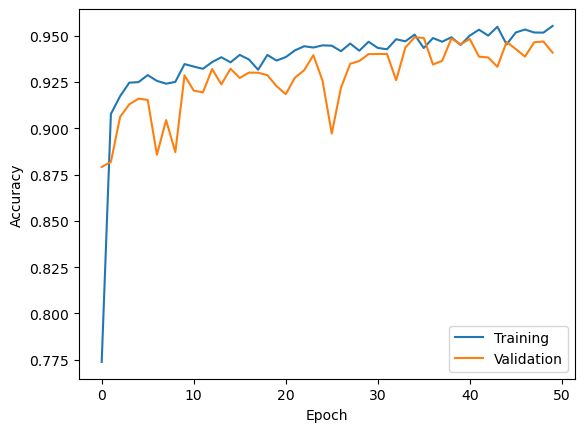

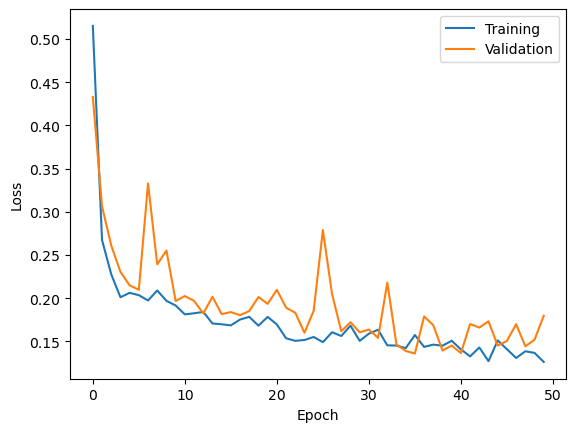

In [40]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_history['accuracy'])
plt.plot(attention_unet_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

## Loss
plt.plot(attention_unet_history['loss'])
plt.plot(attention_unet_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

In [41]:
# Scores of each model
am_unet_score = (score_eval(attention_unet, validation_images, validation_masks))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


In [42]:
# Precision and recall of each model
am_unet_precision = (precision_eval(attention_unet, validation_images, validation_masks))
am_unet_recall = (recall_eval(attention_unet, validation_images, validation_masks))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [43]:
# F1-scores of each model
am_unet_f1_score = (f1_score_eval_basic(am_unet_precision, am_unet_recall))

In [44]:
# Print score eval results for each model
print('Attention U-Net accuracy: ', np.mean(am_unet_score), np.std(am_unet_score))

Attention U-Net accuracy:  0.949015998840332 0.046461544894929103


In [45]:
# Print precision eval results for each model
print('Attention U-Net precision: ', np.mean(am_unet_precision), np.std(am_unet_precision))

Attention U-Net precision:  0.956253480902447 0.03613858768247028


In [46]:
# Print recall eval results for each model
print('Attention U-Net recall: ', np.mean(am_unet_recall), np.std(am_unet_recall))

Attention U-Net recall:  0.949015998840332 0.046461544894929103


In [47]:
# Print f1-score eval results for each model
print('Attention U-Net F1-score: ', np.mean(am_unet_f1_score))

Attention U-Net F1-score:  0.9526209934835015


### 4-band Amazon Data

In [48]:
# Load 4-dim models and history stats
attention_unet_4d = load_model('models_self_trained/unet-attention-4d.keras')
attention_unet_4d_history = np.load('models_self_trained/unet-attention-4d-history.npy', allow_pickle='TRUE').item()

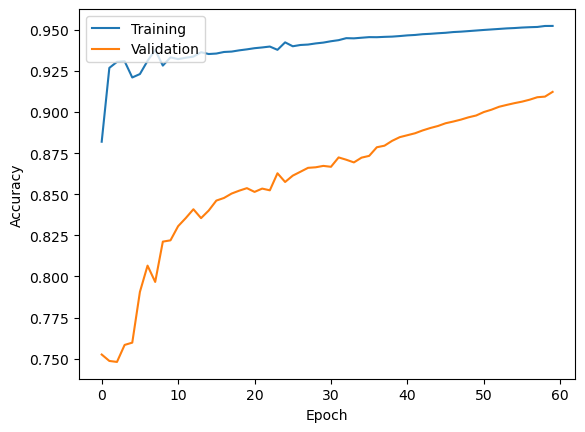

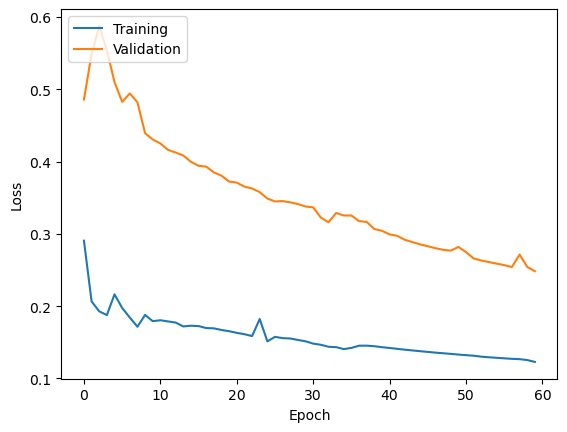

In [49]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_history['accuracy'])
plt.plot(attention_unet_4d_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_history['loss'])
plt.plot(attention_unet_4d_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [50]:
# Scores of each model
am_unet_4d_score = (score_eval2(attention_unet_4d, validation_images2, validation_masks2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [51]:
# Precision and recall of each model
am_unet_4d_precision = (precision_eval(attention_unet_4d, validation_images2, validation_masks2))
am_unet_4d_recall = (recall_eval(attention_unet_4d, validation_images2, validation_masks2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\Gebruiker\AppData\Local\r-miniconda\envs\UCL_DL\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [52]:
# F1-scores of each model
am_unet_4d_f1_score = (f1_score_eval_basic(am_unet_4d_precision, am_unet_4d_recall))

In [53]:
# Print score eval results for each model
print('Attention U-Net accuracy: ', np.mean(am_unet_4d_score), np.std(am_unet_4d_score))

Attention U-Net accuracy:  0.9122661972045898 0.08022375944181125


In [54]:
# Print precision eval results for each model
print('Attention U-Net precision: ', np.mean(am_unet_4d_precision), np.std(am_unet_4d_precision))

Attention U-Net precision:  0.9358321064941445 0.04869059494580973


In [55]:
# Print recall eval results for each model
print('Attention U-Net recall: ', np.mean(am_unet_4d_recall), np.std(am_unet_4d_recall))

Attention U-Net recall:  0.9122661972045898 0.08022375944181125


In [56]:
# Print f1-score eval results for each model
print('Attention U-Net F1-score: ', np.mean(am_unet_4d_f1_score))

Attention U-Net F1-score:  0.9238989022442643


### Amazon on unseen Atlantic data

In [57]:
# Score
am_unet_amazon_on_atlantic_score = score_eval2(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3)

# Precision
am_unet_amazon_on_atlantic_precision = (precision_eval(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))

# Recall
am_unet_amazon_on_atlantic_recall = (recall_eval(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))

# F1-scores of each model
am_unet_amazon_on_atlantic_f1_score = (f1_score_eval_basic(am_unet_amazon_on_atlantic_precision, am_unet_amazon_on_atlantic_recall))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\Gebruiker\AppData\Local\r-miniconda\envs\UCL_DL\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [58]:
# Print metrics
print('Attention U-Net score: ', np.mean(am_unet_amazon_on_atlantic_score), np.std(am_unet_amazon_on_atlantic_score))

print('Attention U-Net precision: ', np.mean(am_unet_amazon_on_atlantic_precision), np.std(am_unet_amazon_on_atlantic_precision))

print('Attention U-Net recall: ', np.mean(am_unet_amazon_on_atlantic_recall), np.std(am_unet_amazon_on_atlantic_recall))

print('Attention U-Net F1-score: ', am_unet_amazon_on_atlantic_f1_score)

Attention U-Net score:  0.888422139485677 0.11258440702053334
Attention U-Net precision:  0.9219831412493249 0.06065091858646614
Attention U-Net recall:  0.888422139485677 0.11258440702053334
Attention U-Net F1-score:  0.9048915661424737


### 4-band Atlantic Data

In [59]:
# Load 4-dim models and history stats
attention_unet_4d_atlantic = load_model('models_self_trained/unet-attention-4d-atlantic.keras')
attention_unet_4d_atlantic_history = np.load('models_self_trained/unet-attention-4d-atlantic-history.npy', allow_pickle='TRUE').item()

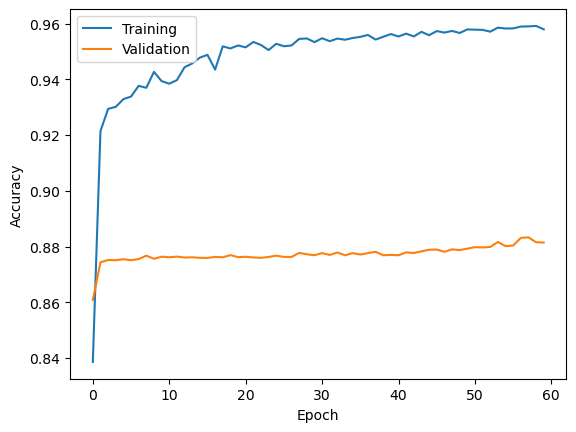

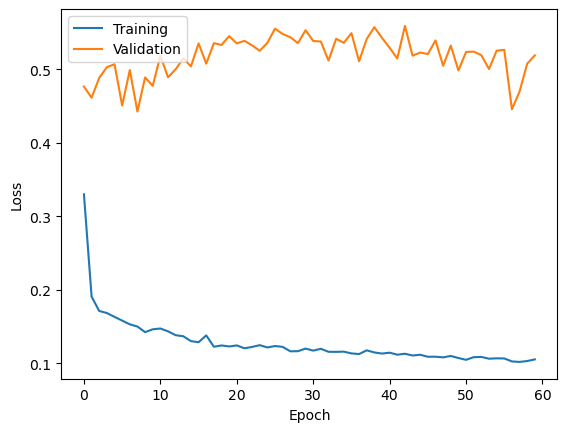

In [60]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_atlantic_history['accuracy'])
plt.plot(attention_unet_4d_atlantic_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_atlantic_history['loss'])
plt.plot(attention_unet_4d_atlantic_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [61]:
# Scores of each model
am_unet_4d_atlantic_score = (score_eval2(attention_unet_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall of each model
am_unet_4d_atlantic_precision = (precision_eval(attention_unet_4d_atlantic, validation_images3, validation_masks3))

am_unet_4d_atlantic_recall = (recall_eval(attention_unet_4d_atlantic, validation_images3, validation_masks3))

# F1-scores of each model
am_unet_4d_atlantic_f1_score = (f1_score_eval_basic(am_unet_4d_atlantic_precision, am_unet_4d_atlantic_recall))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [62]:
# Print metrics
print('Attention U-Net score: ', np.mean(am_unet_4d_atlantic_score), np.std(am_unet_4d_atlantic_score))

print('Attention U-Net precision: ', np.mean(am_unet_4d_atlantic_precision), np.std(am_unet_4d_atlantic_precision))

print('Attention U-Net recall: ', np.mean(am_unet_4d_atlantic_recall), np.std(am_unet_4d_atlantic_recall))

print('Attention U-Net F1-score: ', am_unet_4d_atlantic_f1_score)

Attention U-Net score:  0.8833067321777344 0.11410077960509904
Attention U-Net precision:  0.9302633088810015 0.04726313884353675
Attention U-Net recall:  0.8833067321777344 0.11410077960509904
Attention U-Net F1-score:  0.9061771255912704


### Atlantic on unseen Amazon data

In [63]:
# Score
am_unet_atlantic_on_amazon_score = score_eval2(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2)

# Precision
am_unet_atlantic_on_amazon_precision = (precision_eval(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# Recall
am_unet_atlantic_on_amazon_recall = (recall_eval(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# F1-scores of each model
am_unet_atlantic_on_amazon_f1_score = (f1_score_eval_basic(am_unet_atlantic_on_amazon_precision, am_unet_atlantic_on_amazon_recall))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\Gebruiker\AppData\Local\r-miniconda\envs\UCL_DL\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\Gebruiker\AppData\Local\r-miniconda\envs\UCL_DL\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


In [64]:
# Print metrics
print('Attention U-Net score: ', np.mean(am_unet_atlantic_on_amazon_score), np.std(am_unet_atlantic_on_amazon_score))

print('Attention U-Net precision: ', np.mean(am_unet_atlantic_on_amazon_precision), np.std(am_unet_atlantic_on_amazon_precision))

print('Attention U-Net recall: ', np.mean(am_unet_atlantic_on_amazon_recall), np.std(am_unet_atlantic_on_amazon_recall))

print('Attention U-Net F1-score: ', am_unet_atlantic_on_amazon_f1_score)

Attention U-Net score:  0.9214003245035808 0.058844934668011106
Attention U-Net precision:  0.9395581636763278 0.04200224397808016
Attention U-Net recall:  0.9214003245035808 0.058844934668011106
Attention U-Net F1-score:  0.9303906587922388


### Amazon and Atlantic unseen test data

In [65]:
# Amazon trained model on Amazon test data
# Scores of each model
am_unet_4d_score_test = (score_eval2(attention_unet_4d, test_images2, test_masks2))

# Precision and recall of each model
am_unet_4d_precision_test = (precision_eval(attention_unet_4d, test_images2, test_masks2))

am_unet_4d_recall_test = (recall_eval(attention_unet_4d, test_images2, test_masks2))

# F1-scores of each model
am_unet_4d_f1_score_test = (f1_score_eval_basic(am_unet_4d_precision_test, am_unet_4d_recall_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\Gebruiker\AppData\Local\r-miniconda\envs\UCL_DL\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


In [66]:
# Atlantic trained model on Atlantic test data
# Scores of each model
am_unet_4d_atlantic_score_test = (score_eval2(attention_unet_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
am_unet_4d_atlantic_precision_test = (precision_eval(attention_unet_4d_atlantic, test_images3, test_masks3))

am_unet_4d_atlantic_recall_test = (recall_eval(attention_unet_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
am_unet_4d_atlantic_f1_score_test = (f1_score_eval_basic(am_unet_4d_atlantic_precision_test, am_unet_4d_atlantic_recall_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [67]:
# Print metrics for Amazon on Amazon Test set
print('Attention U-Net score: ', np.mean(am_unet_4d_score_test), np.std(am_unet_4d_score_test))

print('Attention U-Net precision: ', np.mean(am_unet_4d_precision_test), np.std(am_unet_4d_precision_test))

print('Attention U-Net recall: ', np.mean(am_unet_4d_recall_test), np.std(am_unet_4d_recall_test))

print('Attention U-Net F1-score: ', am_unet_4d_f1_score_test)

Attention U-Net score:  0.8726873397827148 0.13595074453599265
Attention U-Net precision:  0.9164397509829101 0.06356975856396005
Attention U-Net recall:  0.8726873397827148 0.13595074453599265
Attention U-Net F1-score:  0.8940285712337676


In [68]:
# Print metrics for Atlantic on Atlantic Test set
print('Attention U-Net score: ', np.mean(am_unet_4d_atlantic_score_test), np.std(am_unet_4d_atlantic_score_test))

print('Attention U-Net precision: ', np.mean(am_unet_4d_atlantic_precision_test), np.std(am_unet_4d_atlantic_precision_test))

print('Attention U-Net recall: ', np.mean(am_unet_4d_atlantic_recall_test), np.std(am_unet_4d_atlantic_recall_test))

print('Attention U-Net F1-score: ', am_unet_4d_atlantic_f1_score_test)

Attention U-Net score:  0.8928888320922852 0.10986444181567702
Attention U-Net precision:  0.9324950491670985 0.03904708741865704
Attention U-Net recall:  0.8928888320922852 0.10986444181567702
Attention U-Net F1-score:  0.9122622632212622


## Produce metric datasets for export

### RGB data

In [69]:
scores_3d = [am_unet_score]
precision_3d = [am_unet_precision]
recall_3d = [am_unet_recall]
f1_scores_3d = [am_unet_f1_score]

import pandas as pd
metrics_3d = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_3d],
              'precision': [np.mean(n) for n in precision_3d],
              'recall': [np.mean(n) for n in recall_3d],
              'f1_score': [np.mean(n) for n in f1_scores_3d],
              'accuracy_std': [np.std(n) for n in scores_3d],
              'precision_std': [np.std(n) for n in precision_3d],
              'recall_std': [np.std(n) for n in recall_3d]
              }
metrics_3d = pd.DataFrame(metrics_3d)

metrics_3d.to_csv('metrics_self_trained/metrics_3d_amazon.csv', index=False)

# Display results
print("\n=== Attention U-Net Metrics ===")
print(metrics_3d)


=== Attention U-Net Metrics ===
        classifier  accuracy  precision    recall  f1_score  accuracy_std  \
0  Attention U-Net  0.949016   0.956253  0.949016  0.952621      0.046462   

   precision_std  recall_std  
0       0.036139    0.046462  


### 4-band Amazon data

In [70]:
# 4D Amazon metrics
scores_4d = [am_unet_4d_score]
precision_4d = [am_unet_4d_precision]
recall_4d = [am_unet_4d_recall]
f1_scores_4d = [am_unet_4d_f1_score]

metrics_4d = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_4d],
              'precision': [np.mean(n) for n in precision_4d],
              'recall': [np.mean(n) for n in recall_4d],
              'f1_score': [np.mean(n) for n in f1_scores_4d],
              'accuracy_std': [np.std(n) for n in scores_4d],
              'precision_std': [np.std(n) for n in precision_4d],
              'recall_std': [np.std(n) for n in recall_4d]
              }
metrics_4d = pd.DataFrame(metrics_4d)
metrics_4d.to_csv('metrics_self_trained/metrics_4d_amazon.csv', index=False)

### 4-band Atlantic Forest data

In [71]:
# 4D Atlantic Forest metrics
scores_4d_atl = [am_unet_4d_atlantic_score]
precision_4d_atl = [am_unet_4d_atlantic_precision]
recall_4d_atl = [am_unet_4d_atlantic_recall]
f1_scores_4d_atl = [am_unet_4d_atlantic_f1_score]

metrics_4d_atl = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_4d_atl],
              'precision': [np.mean(n) for n in precision_4d_atl],
              'recall': [np.mean(n) for n in recall_4d_atl],
              'f1_score': [np.mean(n) for n in f1_scores_4d_atl],
              'accuracy_std': [np.std(n) for n in scores_4d_atl],
              'precision_std': [np.std(n) for n in precision_4d_atl],
              'recall_std': [np.std(n) for n in recall_4d_atl]
              }
metrics_4d_atl = pd.DataFrame(metrics_4d_atl)
metrics_4d_atl.to_csv('metrics_self_trained/metrics_4d_atlantic_forest.csv', index=False)

### Test set data

In [72]:
# 4D Amazon Test metrics
scores_4d_test = [am_unet_4d_score_test]
precision_4d_test = [am_unet_4d_precision_test]
recall_4d_test = [am_unet_4d_recall_test]
f1_scores_4d_test = [am_unet_4d_f1_score_test]

metrics_4d_test = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_4d_test],
              'precision': [np.mean(n) for n in precision_4d_test],
              'recall': [np.mean(n) for n in recall_4d_test],
              'f1_score': [np.mean(n) for n in f1_scores_4d_test],
              'accuracy_std': [np.std(n) for n in scores_4d_test],
              'precision_std': [np.std(n) for n in precision_4d_test],
              'recall_std': [np.std(n) for n in recall_4d_test]
              }
metrics_4d_test = pd.DataFrame(metrics_4d_test)
metrics_4d_test.to_csv('metrics_self_trained/metrics_4d_amazon_test.csv', index=False)

In [73]:
# 4D Atlantic Forest Test metrics
scores_4d_atl_test = [am_unet_4d_atlantic_score_test]
precision_4d_atl_test = [am_unet_4d_atlantic_precision_test]
recall_4d_atl_test = [am_unet_4d_atlantic_recall_test]
f1_scores_4d_atl_test = [am_unet_4d_atlantic_f1_score_test]

metrics_4d_atl_test = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_4d_atl_test],
              'precision': [np.mean(n) for n in precision_4d_atl_test],
              'recall': [np.mean(n) for n in recall_4d_atl_test],
              'f1_score': [np.mean(n) for n in f1_scores_4d_atl_test],
              'accuracy_std': [np.std(n) for n in scores_4d_atl_test],
              'precision_std': [np.std(n) for n in precision_4d_atl_test],
              'recall_std': [np.std(n) for n in recall_4d_atl_test]
              }
metrics_4d_atl_test = pd.DataFrame(metrics_4d_atl_test)
metrics_4d_atl_test.to_csv('metrics_self_trained/metrics_4d_atlantic_forest_test.csv', index=False)

### Testing on opposite dataset (e.g. train on Amazon, test on Atlantic)

In [74]:
# Amazon on Atlantic metrics
scores_amazon_on_atlantic = [am_unet_amazon_on_atlantic_score]
precision_amazon_on_atlantic = [am_unet_amazon_on_atlantic_precision]
recall_amazon_on_atlantic = [am_unet_amazon_on_atlantic_recall]
f1_scores_amazon_on_atlantic = [am_unet_amazon_on_atlantic_f1_score]

metrics_4d_amazon_on_atlantic = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_amazon_on_atlantic],
              'precision': [np.mean(n) for n in precision_amazon_on_atlantic],
              'recall': [np.mean(n) for n in recall_amazon_on_atlantic],
              'f1_score': [np.mean(n) for n in f1_scores_amazon_on_atlantic],
              'accuracy_std': [np.std(n) for n in scores_amazon_on_atlantic],
              'precision_std': [np.std(n) for n in precision_amazon_on_atlantic],
              'recall_std': [np.std(n) for n in recall_amazon_on_atlantic]
              }
metrics_4d_amazon_on_atlantic = pd.DataFrame(metrics_4d_amazon_on_atlantic)
metrics_4d_amazon_on_atlantic.to_csv('metrics_self_trained/metrics_4d_amazon_on_atlantic.csv', index=False)

In [75]:
# Atlantic on Amazon metrics
scores_atlantic_on_amazon = [am_unet_atlantic_on_amazon_score]
precision_atlantic_on_amazon = [am_unet_atlantic_on_amazon_precision]
recall_atlantic_on_amazon = [am_unet_atlantic_on_amazon_recall]
f1_scores_atlantic_on_amazon = [am_unet_atlantic_on_amazon_f1_score]

metrics_4d_atlantic_on_amazon = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_atlantic_on_amazon],
              'precision': [np.mean(n) for n in precision_atlantic_on_amazon],
              'recall': [np.mean(n) for n in recall_atlantic_on_amazon],
              'f1_score': [np.mean(n) for n in f1_scores_atlantic_on_amazon],
              'accuracy_std': [np.std(n) for n in scores_atlantic_on_amazon],
              'precision_std': [np.std(n) for n in precision_atlantic_on_amazon],
              'recall_std': [np.std(n) for n in recall_atlantic_on_amazon]
              }
metrics_4d_atlantic_on_amazon = pd.DataFrame(metrics_4d_atlantic_on_amazon)
metrics_4d_atlantic_on_amazon.to_csv('metrics_self_trained/metrics_4d_atlantic_on_amazon.csv', index=False)

## Jaccard Index/IoU Score

In [76]:
def jaccard_index(model, images, masks):

  preds = []
  for n in images:
    preds.append(reconstruct_array(model, n, rounded=True))

  jaccard_list = []

  # Jaccard computation
  for i in range(len(preds)):
    flat_pred = preds[i].flatten()
    flat_act =  masks[i].flatten()

    # Compute coeff (add 1 to numerator and denominator to prevent some errors)
    jaccard_list.append(jaccard_score(flat_act, flat_pred, average='weighted'))

  return np.mean(jaccard_list), np.std(jaccard_list)

In [77]:
attention_unet_3d_jaccard = jaccard_index(attention_unet, validation_images, validation_masks)
attention_unet_4d_jaccard = jaccard_index(attention_unet_4d, validation_images2, validation_masks2)
attention_unet_4d1_jaccard = jaccard_index(attention_unet_4d_atlantic, validation_images3, validation_masks3)
attention_unet_4d_jaccard_test = jaccard_index(attention_unet_4d, test_images2, test_masks2)
attention_unet_4d1_jaccard_test = jaccard_index(attention_unet_4d_atlantic, test_images3, test_masks3)
attention_unet_4d_jaccard_onatl = jaccard_index(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3)
attention_unet_4d1_jaccard_onam = jaccard_index(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [78]:
# Output to file

# Create lists of all types of Jaccard metrics
jaccard_row = {
    "classifier":           "Attention U-Net",
    "3d":                   attention_unet_3d_jaccard[0],
    "amazon":               attention_unet_4d_jaccard[0],
    "atlantic":             attention_unet_4d1_jaccard[0],
    "amazon_test":          attention_unet_4d_jaccard_test[0],
    "atlantic_test":        attention_unet_4d1_jaccard_test[0],
    "amazon_on_atlantic":   attention_unet_4d_jaccard_onatl[0],
    "atlantic_on_amazon":   attention_unet_4d1_jaccard_onam[0],
}

# Create DataFrame with a single row
jaccard_metrics = pd.DataFrame([jaccard_row])

# Save to CSV
jaccard_metrics.to_csv("metrics_self_trained/jaccard_metrics.csv", index=False)

# Comparison with baseline results in paper

In [105]:
from pathlib import Path

# === 1. Path to your CSV files ==================================================
METRICS_DIR = Path("metrics_self_trained")  # Adjust if your CSVs are stored elsewhere

# Mapping: filename → (Dataset name, Split label)
file_map = {
    "metrics_3d_amazon.csv":                ("RGB Amazon (3-band)",      "Validation"),
    "metrics_4d_amazon.csv":                ("4-band Amazon",            "Validation"),
    "metrics_4d_amazon_test.csv":           ("4-band Amazon",            "Test"),
    "metrics_4d_atlantic_forest.csv":       ("4-band Atlantic Forest",   "Validation"),
    "metrics_4d_atlantic_forest_test.csv":  ("4-band Atlantic Forest",   "Test"),
    "metrics_4d_amazon_on_atlantic.csv":    ("4-band Amazon→Atlantic",   "Test"),
    "metrics_4d_atlantic_on_amazon.csv":    ("4-band Atlantic→Amazon",   "Test"),
}

# === 2. Read your own (self-trained) precision/recall/F1/accuracy ==============
our_rows = []

for fname, (dataset, split) in file_map.items():
    df = pd.read_csv(METRICS_DIR / fname)
    row = df.iloc[0]  # Each CSV contains only one classifier row

    our_rows.append({
        "Dataset":   dataset,
        "Split":     split,
        "Source":    "Ours",
        "IoU":       np.nan,                     # Will be filled from Jaccard file below
        "Precision": float(row["precision"]),
        "Recall":    float(row["recall"]),
        "F1":        float(row["f1_score"]),
        "Accuracy":  float(row["accuracy"]),
    })

our_df = pd.DataFrame(our_rows)

# === 2b. Read Jaccard / IoU metrics and fill IoU for our runs ==================
# Assumes a file 'jaccard_metrics.csv' with columns:
# classifier,3d,amazon,atlantic,amazon_test,atlantic_test,amazon_on_atlantic,atlantic_on_amazon
jaccard_df = pd.read_csv(METRICS_DIR / "jaccard_metrics.csv")
j = jaccard_df.iloc[0]  # Only Attention U-Net row

# Map Jaccard columns to the dataset labels used in our_df
jaccard_map = {
    "3d":                 ("RGB Amazon (3-band)",     "Validation"),
    "amazon":             ("4-band Amazon",           "Validation"),
    "atlantic":           ("4-band Atlantic Forest",  "Validation"),
    "amazon_test":        ("4-band Amazon",           "Test"),
    "atlantic_test":      ("4-band Atlantic Forest",  "Test"),
    "amazon_on_atlantic": ("4-band Amazon→Atlantic",  "Test"),
    "atlantic_on_amazon": ("4-band Atlantic→Amazon",  "Test"),
}

for col_name, (dataset_name, split_name) in jaccard_map.items():
    value = float(j[col_name])
    mask = (
        (our_df["Dataset"] == dataset_name) &
        (our_df["Split"] == split_name) &
        (our_df["Source"] == "Ours")
    )
    our_df.loc[mask, "IoU"] = value

# === 3. Paper metrics for Attention U-Net (Tables 3–6) =========================
# Format: (Dataset, Split, IoU, Precision, Recall, F1)
paper_data = [
    # Table 5 — RGB Amazon (3-band)
    ("RGB Amazon (3-band)",     "Validation", 0.9028, 0.9574, 0.9526, 0.9550),

    # Table 3 — 4-band Amazon
    ("4-band Amazon",           "Validation", 0.9581, 0.9790, 0.9779, 0.9785),
    ("4-band Amazon",           "Test",       0.9516, 0.9758, 0.9748, 0.9753),

    # Table 4 — 4-band Atlantic Forest
    ("4-band Atlantic Forest",  "Validation", 0.9120, 0.9563, 0.9520, 0.9541),
    ("4-band Atlantic Forest",  "Test",       0.9199, 0.9591, 0.9571, 0.9581),

    # Table 6 — Cross-location generalisation
    ("4-band Amazon→Atlantic",  "Test",       0.8143, 0.9222, 0.8829, 0.9021),
    ("4-band Atlantic→Amazon",  "Test",       0.8722, 0.9445, 0.9266, 0.9355),
]

paper_df = pd.DataFrame(
    paper_data,
    columns=["Dataset", "Split", "IoU", "Precision", "Recall", "F1"]
)
paper_df["Source"]   = "Paper"
paper_df["Accuracy"] = np.nan  # Paper does not report accuracy

# === 4. Combine paper + our results ============================================
combined = pd.concat([paper_df, our_df], ignore_index=True)

# Ensure ordering: Paper first, then Ours for each dataset/split
combined["Source"] = pd.Categorical(
    combined["Source"], categories=["Paper", "Ours"], ordered=True
)

combined = combined.sort_values(["Dataset", "Split", "Source"], ignore_index=True)
# === Remove Accuracy and add "(Paper)" / "(Ours)" to dataset names ==========
# 1. Make a copy so we don't modify the original accidentally
combined2 = combined.copy()
# 2. Drop the Accuracy column
combined2 = combined2.drop(columns=["Accuracy"])

# 3. Append "(Paper)" or "(Ours)" to Dataset labels
combined2["Dataset"] = combined2.apply(
    lambda row: f"{row['Dataset']} ({row['Source']})", axis=1
)

# 4. Remove the Source column since it's now encoded in Dataset name
combined2 = combined2.drop(columns=["Source"])

# 5. Sort for nicer output
combined2 = combined2.sort_values(["Dataset", "Split"], ignore_index=True)
md_table = combined2.to_markdown(index=False, floatfmt=".4f")

# print("\n===== Markdown Table (copy this into a Markdown cell) =====\n")
# print(md_table)

| Dataset                        | Split      |    IoU |   Precision |   Recall |     F1 |
|:-------------------------------|:-----------|-------:|------------:|---------:|-------:|
| 4-band Amazon (Ours)           | Test       | 0.7898 |      0.9164 |   0.8727 | 0.8940 |
| 4-band Amazon (Ours)           | Validation | 0.8488 |      0.9358 |   0.9123 | 0.9239 |
| 4-band Amazon (Paper)          | Test       | 0.9516 |      0.9758 |   0.9748 | 0.9753 |
| 4-band Amazon (Paper)          | Validation | 0.9581 |      0.9790 |   0.9779 | 0.9785 |
| 4-band Amazon→Atlantic (Ours)  | Test       | 0.8206 |      0.9220 |   0.8884 | 0.9049 |
| 4-band Amazon→Atlantic (Paper) | Test       | 0.8143 |      0.9222 |   0.8829 | 0.9021 |
| 4-band Atlantic Forest (Ours)  | Test       | 0.8287 |      0.9325 |   0.8929 | 0.9123 |
| 4-band Atlantic Forest (Ours)  | Validation | 0.8178 |      0.9303 |   0.8833 | 0.9062 |
| 4-band Atlantic Forest (Paper) | Test       | 0.9199 |      0.9591 |   0.9571 | 0.9581 |
| 4-band Atlantic Forest (Paper) | Validation | 0.9120 |      0.9563 |   0.9520 | 0.9541 |
| 4-band Atlantic→Amazon (Ours)  | Test       | 0.8620 |      0.9396 |   0.9214 | 0.9304 |
| 4-band Atlantic→Amazon (Paper) | Test       | 0.8722 |      0.9445 |   0.9266 | 0.9355 |
| RGB Amazon (3-band) (Ours)     | Validation | 0.9072 |      0.9563 |   0.9490 | 0.9526 |
| RGB Amazon (3-band) (Paper)    | Validation | 0.9028 |      0.9574 |   0.9526 | 0.9550 |